In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

import itertools

from cpd_utils import *

import time
import bisect

import pandas as pd

# DCDP

In [2]:
djia = pd.read_csv('DJIA.csv')

In [31]:
djia

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,ix,time
0,-0.041385,-0.060233,-0.062160,-0.003771,0.004348,0.000000,0.016894,-0.032790,-0.006390,-0.026938,...,-0.022473,-0.037388,-0.028072,-0.007561,-0.006857,-0.017452,-0.060871,0.008396,1,1990-04-02
1,0.029385,0.004184,0.013483,0.036414,-0.010834,0.000000,0.029257,0.066691,0.023197,0.010017,...,0.007435,0.029797,0.066155,0.036437,0.013762,0.008107,0.046333,-0.013401,2,1990-04-09
2,-0.007921,0.064958,-0.002260,0.025702,-0.021323,0.000000,-0.004040,-0.013699,0.022414,0.023770,...,0.007491,-0.016870,0.022431,0.031749,0.028105,0.029501,0.016632,0.030408,3,1990-04-16
3,0.005935,-0.019934,-0.059163,-0.073965,-0.016737,0.000000,-0.040822,-0.010152,-0.028911,-0.023770,...,0.015152,-0.050736,-0.007533,0.000000,-0.039586,-0.052490,-0.047092,-0.032070,4,1990-04-23
4,-0.029328,-0.065771,0.002130,-0.052532,-0.052537,0.000000,-0.020435,-0.040687,0.005195,-0.039479,...,-0.059277,-0.026157,-0.049415,-0.021935,-0.018100,-0.055263,-0.054488,-0.042283,5,1990-04-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,-0.056512,-0.026849,-0.104279,-0.008515,-0.055332,-0.044865,-0.017805,-0.005535,-0.062286,-0.040640,...,0.003306,0.005347,0.004142,-0.003083,-0.011016,0.032609,0.012802,-0.004291,1134,2011-12-19
1134,-0.067967,-0.030405,-0.067477,-0.008308,-0.067805,-0.011173,0.020772,-0.050167,0.038569,-0.010312,...,-0.012224,0.008306,-0.013059,-0.000342,-0.029019,-0.015385,-0.009234,0.002859,1135,2011-12-26
1135,-0.037284,-0.005650,-0.067474,-0.012267,-0.034918,-0.043992,-0.007543,-0.020782,-0.023421,-0.016069,...,-0.002800,-0.014263,-0.014238,-0.036587,-0.007950,-0.001052,-0.024381,-0.030309,1136,2012-01-02
1136,-0.025392,0.003830,-0.030729,0.012945,-0.051954,0.017880,0.027777,-0.025986,0.001527,0.006397,...,0.019290,0.029516,0.045095,0.059060,-0.012069,0.046007,0.004996,0.019159,1137,2012-01-09


In [29]:
djia['time']

0       1990-04-02
1       1990-04-09
2       1990-04-16
3       1990-04-23
4       1990-04-30
           ...    
1133    2011-12-19
1134    2011-12-26
1135    2012-01-02
1136    2012-01-09
1137    2012-01-16
Name: time, Length: 1138, dtype: object

In [67]:
nt = len(djia['V1'])
Y = djia.iloc[:, np.arange(29)].values
Y_scale = Y / np.std(Y, axis = 0)
# Y_train = Y_scale[np.arange(0, nt, 2), :]
# Y_test = Y_scale[np.arange(1, nt, 2), :]
Y_train = Y[np.arange(0, nt, 2), :]
Y_test = Y[np.arange(1, nt, 2), :]

In [63]:
print(Y_train.shape)
print(Y_test.shape)

(569, 29)
(569, 29)


(array([3.0000e+00, 4.0000e+00, 4.5000e+01, 1.3510e+03, 1.2791e+04,
        2.1840e+03, 9.7000e+01, 1.8000e+01, 4.0000e+00, 4.0000e+00]),
 array([-9.84087051, -7.69360751, -5.54634452, -3.39908153, -1.25181853,
         0.89544446,  3.04270745,  5.18997045,  7.33723344,  9.48449644,
        11.63175943]),
 <a list of 10 Patch objects>)

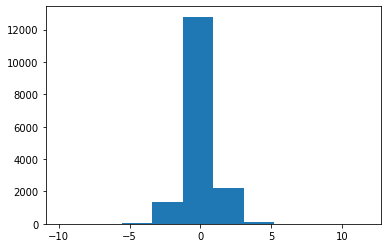

In [64]:
plt.hist(Y_train.reshape((-1,)))

In [65]:
y_max = Y.max(axis = (0,1))
y_max

0.5928031

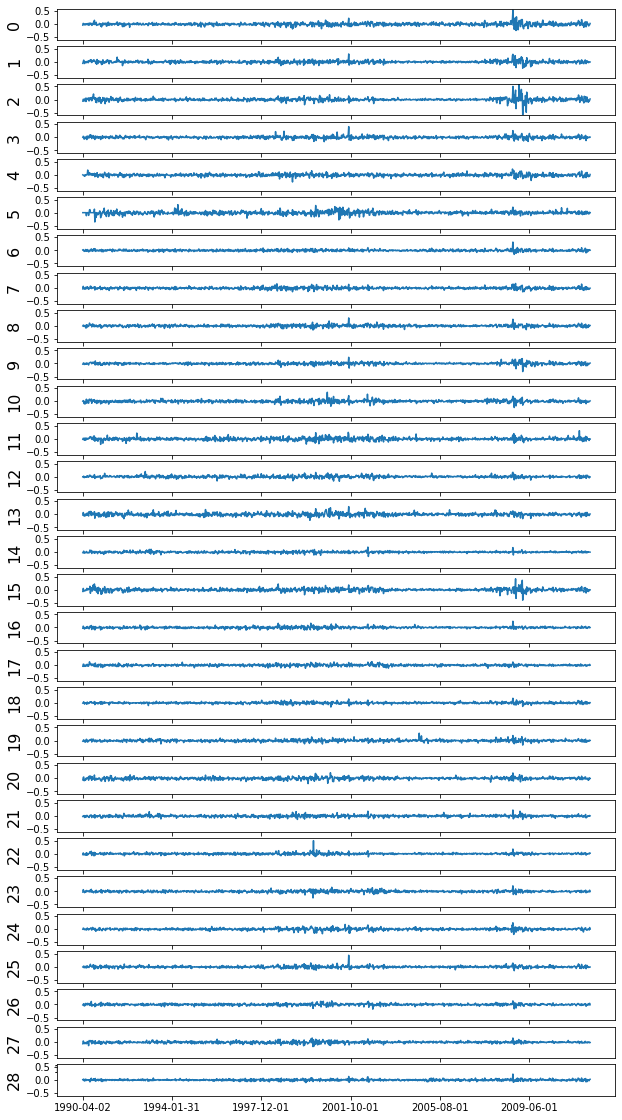

In [8]:
import matplotlib.gridspec as gridspec

Y = djia.iloc[:, np.arange(29)].values
n = Y.shape[0]
p = Y.shape[1]
ix = np.arange(n)

y_max = Y.max(axis = (0,1))
y_min = Y.min(axis = (0,1))

gs = gridspec.GridSpec(p, 1)
fig = plt.figure(figsize = (10, 20))

for i in range(p - 1):
    ax = fig.add_subplot(gs[i])
    ax.plot(ix, Y[:, i])
    plt.ylim([y_min, y_max])
    ax.set_ylabel(str(i), size =16)
#     ax.get_yaxis().set_label_coords(y_min, y_max)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        labelbottom='off') # labels along the bottom edge are off

# the last plot
ax = fig.add_subplot(gs[p - 1], sharex = ax)
ax.plot(ix, Y[:, p - 1])
ax.set_ylabel(str(p - 1), size =16)
# ax.get_yaxis().set_label_coords(y_min, y_max)
plt.ylim([y_min, y_max])
x = ax.get_xticks().tolist()
for i, v in enumerate(x):
    if v < n:
        x[i] = djia['time'].values[int(v)]
ax.set_xticklabels(x)

plt.show()

In [11]:
grid_n = 200
gamma_list = [0.05, 0.1]
lam_list = [0, 0.5]

np.random.seed(0)

run_time_dc  = 0
loc_error_dc = 0

print('---------- divide and conquer -----------')
start_time = time.time()
dcdp = dcdp_cv_random_mean(grid_n, lam_list, gamma_list, smooth = 5, 
             buffer = 10, step_refine = 1, buffer_refine = 5, lam_refine = 0.1)
cp_best, param_best, cp_best_cand = dcdp.fit(Y_train, Y_test)
# loc_error_dc = cp_distance(cp_best, cp_truth)
# run_time_dc = time.time() - start_time

# print("loc error: {0}, time: {1}".format(loc_error_dc, run_time_dc))
# print("best parameter: {0}".format(param_best))

---------- divide and conquer -----------


In [12]:
print(cp_best)
print(cp_best_cand)

[]
[]


In [14]:
# cp = np.concatenate([[0], cp_best_cand[:], [len(Y_train)]])
# beta_path = dcdp.fit_with_cp(Y_train, cp)

In [15]:
# print(beta_path)
# print(theta)

### Change in covariance

In [16]:
# w = 10
# nt = Y.shape[0]

# for i in range(nt - w):
    

In [ ]:
grid_n = 100
repeat = 1
gamma_list = [5, 20, 50]
lam_list = [0]

B = 1
run_time_dc = np.zeros(B)
loc_error_dc = np.zeros(B)

print('---------- divide and conquer -----------')
for b in range(B):
    start_time = time.time()
    dcdp = dcdp_cv_random_covariance(grid_n, repeat, lam_list, gamma_list, smooth = 10, 
                 buffer = 20, step_refine = 1, buffer_refine = 10, lam_refine = 0.1)
    cp_best, param_best, cp_best_cand = dcdp.fit(Y_train, Y_test)
    loc_error_dc[b] = cp_distance(cp_best, cp_truth)
    run_time_dc[b] = time.time() - start_time

print("avg loc error: {0}, avg time: {1}".format(loc_error_dc.mean(), run_time_dc.mean()))
print("best parameter: {0}".format(param_best))

In [20]:
grid_n = 200
gamma_list = [20]
lam_list = [0, 0.5]

run_time_dc  = 0
loc_error_dc = 0

print('---------- divide and conquer -----------')
start_time = time.time()
dcdp = dcdp_cv_random_covariance(grid_n, lam_list, gamma_list, smooth = 5, 
             buffer = 10, step_refine = 1, buffer_refine = 5, lam_refine = 0.1)
cp_best, param_best, cp_best_cand = dcdp.fit(Y_train, Y_test)
# loc_error_dc = cp_distance(cp_best, cp_truth)
# run_time_dc = time.time() - start_time

# print("loc error: {0}, time: {1}".format(loc_error_dc, run_time_dc))
print("best parameter: {0}".format(param_best))

---------- divide and conquer -----------
best parameter: (0, 20)


In [21]:
print(cp_best)
print(cp_best_cand)

[]
[]


In [22]:
cp_time = []
for cp in cp_best:
    cp_time.append(djia['time'].values[2 * cp])
print(cp_time)

[]


In [23]:
grid_n = 200
gamma_list = [15]
lam_list = [0, 0.5]

run_time_dc  = 0
loc_error_dc = 0

print('---------- divide and conquer -----------')
start_time = time.time()
dcdp = dcdp_cv_random_covariance(grid_n, lam_list, gamma_list, smooth = 5, 
             buffer = 10, step_refine = 1, buffer_refine = 5, lam_refine = 0.1)
cp_best, param_best, cp_best_cand = dcdp.fit(Y_train, Y_test)
# loc_error_dc = cp_distance(cp_best, cp_truth)
# run_time_dc = time.time() - start_time

# print("loc error: {0}, time: {1}".format(loc_error_dc, run_time_dc))
print("best parameter: {0}".format(param_best))

---------- divide and conquer -----------
best parameter: (0, 15)


In [24]:
print(cp_best)
print(cp_best_cand)

[482, 498]
[481 497]


In [25]:
cp_time = []
for cp in cp_best:
    cp_time.append(djia['time'].values[2 * cp])
print(cp_time)

['2008-09-22', '2009-05-04']


In [68]:
grid_n = 200
gamma_list = [10]
lam_list = [0, 0.5]

run_time_dc  = 0
loc_error_dc = 0

print('---------- divide and conquer -----------')
np.random.seed(0)
start_time = time.time()
dcdp = dcdp_cv_random_covariance(grid_n, lam_list, gamma_list, smooth = 5, 
             buffer = 10, step_refine = 1, buffer_refine = 5, lam_refine = 0.1)
cp_best, param_best, cp_best_cand = dcdp.fit(Y_train, Y_test)
# loc_error_dc = cp_distance(cp_best, cp_truth)
# run_time_dc = time.time() - start_time

# print("loc error: {0}, time: {1}".format(loc_error_dc, run_time_dc))
print("best parameter: {0}".format(param_best))
print(time.time() - start_time)

---------- divide and conquer -----------
best parameter: (0, 10)
40.4295711517334


In [69]:
print(cp_best)
print(cp_best_cand)

[482, 498]
[479 501]


In [70]:
cp_time = []
for cp in cp_best:
    cp_time.append(djia['time'].values[2 * cp])
print(cp_time)

['2008-09-22', '2009-05-04']


In [71]:
cp_all = [0] + [cp * 2 for cp in cp_best] + [Y.shape[0]]
Y_scale = Y / np.std(Y, axis = 0)
cov_list = dcdp.fit_with_cp(Y_scale, cp_all)

In [72]:
len(cov_list)

3

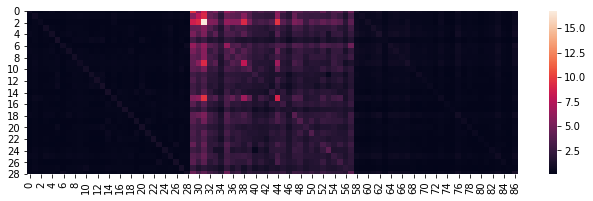

In [56]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (11, 3), nrows = 1, ncols = 1)

cov_all = np.concatenate([cov_list[0], cov_list[1], cov_list[2]], axis = 1)
sns.heatmap(cov_all, ax = ax)

In [80]:
np.tile(np.arange(3),2)

array([0, 1, 2, 0, 1, 2])

In [88]:
np.arange(0, 10, 2)

array([0, 2, 4, 6, 8])

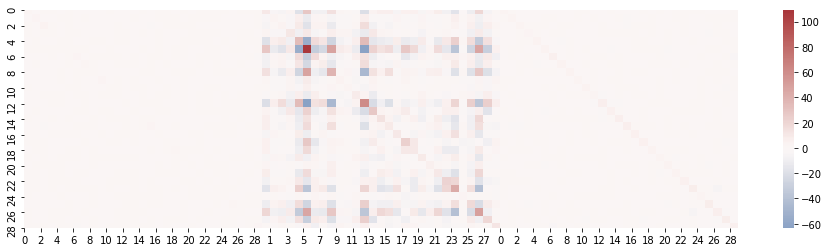

In [92]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (16, 4), nrows = 1, ncols = 1)

omega_all = np.concatenate([np.linalg.inv(cov_list[0]), 
                            np.linalg.inv(cov_list[1]), 
                            np.linalg.inv(cov_list[2])], axis = 1)
sns.heatmap(omega_all, ax = ax, cmap = "vlag", center = 0)
x = plt.xticks(np.arange(0, 87, 2), np.tile(np.arange(29),3)[::2])
plt.savefig('djia_precision.pdf', bbox_inches = 'tight')

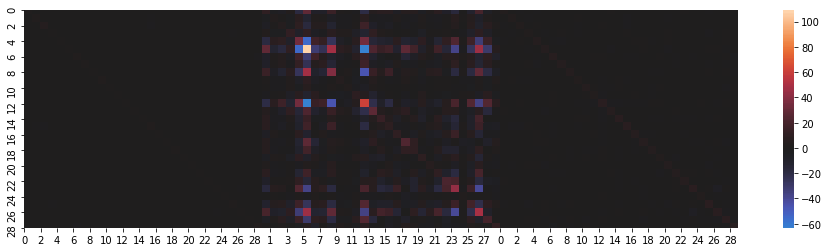

In [91]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (16, 4), nrows = 1, ncols = 1)

omega_all = np.concatenate([np.linalg.inv(cov_list[0]), 
                            np.linalg.inv(cov_list[1]), 
                            np.linalg.inv(cov_list[2])], axis = 1)
sns.heatmap(omega_all, ax = ax, cmap = "icefire", center = 0)
x = plt.xticks(np.arange(0, 87, 2), np.tile(np.arange(29),3)[::2])

(array([  4.,  12., 524., 272.,   0.,  17.,   5.,   5.,   1.,   1.]),
 array([-1.84317845e+00, -1.23008931e+00, -6.17000171e-01, -3.91103093e-03,
         6.09178109e-01,  1.22226725e+00,  1.83535639e+00,  2.44844553e+00,
         3.06153467e+00,  3.67462381e+00,  4.28771295e+00]),
 <a list of 10 Patch objects>)

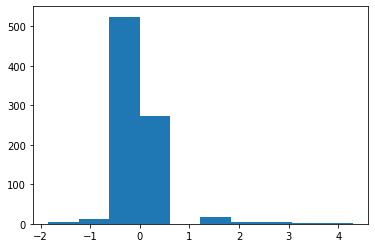

In [73]:
pre0 = np.linalg.inv(cov_list[0]).reshape((-1,))
plt.hist(pre0)

In [34]:
grid_n = 200
gamma_list = [5]
lam_list = [0, 0.5]

run_time_dc  = 0
loc_error_dc = 0

print('---------- divide and conquer -----------')
np.random.seed(0)
start_time = time.time()
dcdp = dcdp_cv_random_covariance(grid_n, lam_list, gamma_list, smooth = 5, 
             buffer = 10, step_refine = 1, buffer_refine = 5, lam_refine = 0.1)
cp_best, param_best, cp_best_cand = dcdp.fit(Y_train, Y_test)
# loc_error_dc = cp_distance(cp_best, cp_truth)
# run_time_dc = time.time() - start_time

# print("loc error: {0}, time: {1}".format(loc_error_dc, run_time_dc))
print("best parameter: {0}".format(param_best))
print(time.time() - start_time)

---------- divide and conquer -----------
best parameter: (0.5, 5)


In [35]:
print(cp_best)
print(cp_best_cand)

[214, 478, 498]
[298 299 482 486 499]


In [40]:
cp_time = []
for cp in cp_best:
    cp_time.append(djia['time'].values[2 * cp])
print(cp_time)

['1998-06-15', '2008-07-28', '2009-05-04']


In [26]:
grid_n = 200
gamma_list = [10]
lam_list = [0, 0.5]

run_time_dc  = 0
loc_error_dc = 0

print('---------- divide and conquer -----------')
start_time = time.time()
dcdp = dcdp_cv_random_covariance(grid_n, lam_list, gamma_list, smooth = 5, 
             buffer = 10, step_refine = 1, buffer_refine = 10, lam_refine = 0.1)
cp_best, param_best, cp_best_cand = dcdp.fit(Y_train, Y_test)
# loc_error_dc = cp_distance(cp_best, cp_truth)
# run_time_dc = time.time() - start_time

# print("loc error: {0}, time: {1}".format(loc_error_dc, run_time_dc))
print("best parameter: {0}".format(param_best))

---------- divide and conquer -----------
best parameter: (0, 10)


In [27]:
print(cp_best)
print(cp_best_cand)

[481]
[481 499]


In [28]:
cp_time = []
for cp in cp_best:
    cp_time.append(djia['time'].values[2 * cp])
print(cp_time)

['2008-09-08']


In [93]:
np.linspace(0, 10, 3)

array([ 0.,  5., 10.])

In [100]:
n = 20
grid_n = 10
grid_n = min(grid_n, n - 1)
step = max(n // grid_n, 1)
grid = np.arange(0, n, step)
print(grid)
print(len(grid))

[ 0  2  4  6  8 10 12 14 16 18]
10


In [99]:
np.unique(np.concatenate([[0], grid, [n]]))

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [112]:
n = 20
grid_n = 19
grid_n = min(grid_n, n - 1)
step = n / (grid_n + 1)
grid = np.arange(1, grid_n + 1) * step
print(grid)
print(len(grid))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19.]
19


In [114]:
n = 20
grid_n = 10
grid_n = min(grid_n, n - 1)
step = n / (grid_n + 1)
grid = np.floor(np.arange(1, grid_n + 1) * step).astype(int)
print(grid)
print(len(grid))

[ 1  3  5  7  9 10 12 14 16 18]
10
